In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-08-31 15:53:19 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-08-31 15:53:21 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-08-31 15:53:21 __main__ INFO     transformers.__version__='4.55.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.1-70B-Instruct"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-08-31 15:53:24 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-31 15:53:24 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-31 15:53:24 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-08-31 15:53:24 wandb.docker.auth DEBUG    No config file found


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-08-31 15:53:25 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-08-31 15:53:25 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-08-31 15:53:25 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-08-31 15:53:25 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-08-31 15:53:25 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-08-31 15:54:14 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-08-31 15:54:14 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-08-31 15:54:15 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [5]:
device_map = get_device_map(mt.name, 80, n_gpus=8)

def module_to_device(module_name):
    for key in device_map:
        if module_name.startswith(key):
            return f"cuda:{device_map[key]}"
    return "cpu"

module_to_device(mt.mlp_module_name_format.format(20))

'cuda:2'

In [6]:
from src.selection.data import SelectOneTask, SelectOrderTask

#################################################################################
# TASK_CLS = SelectOrderTask
# prompt_template_idx = 1
TASK_CLS = SelectOneTask
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

print(select_task)

SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



## Patching the residual states

In [7]:
import copy
import random
from src.selection.utils import KeyedSet, get_first_token_id, verify_correct_option
from src.selection.data import SelectionSample
from src.functional import predict_next_token
from src.tokens import prepare_input
from src.selection.data import get_counterfactual_samples_within_task

In [8]:
patch_sample, clean_sample = get_counterfactual_samples_within_task(
    # patch_category="politician",
    # clean_category="actor",
    mt=mt,
    task=select_task,
    patch_category="fruit",
    clean_category="vehicle",
    filter_by_lm_prediction=True,
    prompt_template_idx=prompt_template_idx,
    option_style=OPTION_STYLE,
    distinct_options=True,
    patch_n_distractors=5,
    clean_n_distractors=5
)

# patch_sample.default_option_style = "single_line"
# clean_sample.default_option_style = "numbered"

print(patch_sample.prompt(), ">>", patch_sample.obj)
print(clean_sample.prompt(), ">>", clean_sample.obj)

2025-08-31 01:21:19 src.selection.data INFO     clean_obj_idx=5 | ['Xylophone', 'Calculator', 'Maple', 'Pear', 'Sunflower', 'Train']


type(task)=<class 'src.selection.data.SelectOneTask'>
2025-08-31 01:21:20 src.selection.data INFO     # Options: Comb, Slow cooker, Cherry, Socks, Airplane, Rabbit.
Which among these objects mentioned above is a fruit?
Answer:
2025-08-31 01:21:20 src.selection.data INFO     Peach | fruit -> Cherry | pred=['" Cherry"[44705] (p=0.570, logit=25.375)', '" The"[576] (p=0.237, logit=24.500)', '" Among"[21658] (p=0.127, logit=23.875)', '" \n"[715] (p=0.025, logit=22.250)', '" \n\n"[4710] (p=0.012, logit=21.500)']
2025-08-31 01:21:20 src.selection.data INFO     # Options: Xylophone, Calculator, Maple, Pear, Sunflower, Train.
Which among these objects mentioned above is a vehicle?
Answer:
2025-08-31 01:21:20 src.selection.data INFO     Car | vehicle -> Train | pred=['" Train"[26125] (p=0.859, logit=30.875)', '" The"[576] (p=0.103, logit=28.750)', '" Among"[21658] (p=0.011, logit=26.500)', '" \n"[715] (p=0.008, logit=26.250)', '" To"[2014] (p=0.007, logit=26.125)']
2025-08-31 01:21:21 src.select

In [9]:
clean_tokenized = prepare_input(tokenizer=mt, prompts=clean_sample.prompt())
print(mt.tokenizer.decode(clean_tokenized.input_ids[0], skip_special_tokens=False))

# Options: Xylophone, Calculator, Maple, Pear, Sunflower, Train.
Which among these objects mentioned above is a vehicle?
Answer:


In [10]:
from src.tokens import prepare_input
from src.selection.utils import get_first_token_id
from src.functional import interpret_logits, PatchSpec
from itertools import product
from src.utils.typing import TokenizerOutput, ArrayLike
from typing import Optional, Union
from src.functional import get_module_nnsight, untuple, get_hs, predict_next_token

def layer_wise_patching(
    mt: ModelandTokenizer,
    patch_sample: SelectionSample,
    clean_sample: SelectionSample,
    token_indices: list[int] = [-3, -2, -1],
):
    patch_tokenized = prepare_input(
        tokenizer=mt.tokenizer, prompts=patch_sample.prompt()
    )
    clean_tokenized = prepare_input(
        tokenizer=mt.tokenizer, prompts=clean_sample.prompt()
    )

    random_idx = random.choice(
        list(
            set(list(range(len(clean_sample.options))))
            - {
                patch_sample.obj_idx,
                clean_sample.obj_idx,
                clean_sample.metadata["track_type_obj_idx"],
            }
        )
    )

    track_tokens = {
        "predicate_target": clean_sample.metadata["track_type_obj_token_id"],
        "clean_ans": get_first_token_id(clean_sample.obj, mt.tokenizer, prefix=" "),
        "patch_ans": get_first_token_id(patch_sample.obj, mt.tokenizer, prefix=" "),
        "patch_position": get_first_token_id(
            clean_sample.options[patch_sample.obj_idx], mt.tokenizer, prefix=" "
        ),
        "random_distractor": get_first_token_id(
            clean_sample.options[random_idx], mt.tokenizer, prefix=" "
        ),
    }

    ret = {"track_tokens": track_tokens}

    logit_location = (mt.lm_head_name, -1)
    patch_locations = list(product(mt.layer_names, token_indices))
    # patch_locations = []
    print(patch_locations)

    patch_hs = get_hs(
        mt=mt,
        input=patch_tokenized,
        locations=patch_locations + [logit_location],
        return_dict=True,
    )
    patch_logits = patch_hs[logit_location]
    patch_pred, patch_track = interpret_logits(
        tokenizer=mt.tokenizer,
        logits=patch_logits,
        interested_tokens=track_tokens.values(),
    )
    logger.debug(f"patch_pred={[str(pred) for pred in patch_pred]}")
    logger.debug(f"patch_track={patch_track}")
    ret["patch_pred"] = patch_pred
    ret["patch_track"] = patch_track

    clean_hs = get_hs(
        mt=mt,
        input=clean_tokenized,
        locations=patch_locations + [logit_location],
        return_dict=True,
    )
    clean_logits = clean_hs[logit_location]
    clean_pred, clean_track = interpret_logits(
        tokenizer=mt.tokenizer,
        logits=clean_logits,
        interested_tokens=track_tokens.values(),
    )
    logger.debug(f"clean_pred={[str(pred) for pred in clean_pred]}")
    logger.debug(f"clean_track={clean_track}")
    ret["clean_pred"] = clean_pred
    ret["clean_track"] = clean_track

    layer_wise_patching_results = {}
    for layer in mt.layer_names:
        patch_spec = []
        for token_idx in token_indices:
            patch_spec.append(
                PatchSpec(
                    location=(layer, token_idx), patch=patch_hs[(layer, token_idx)]
                )
            )

        # int_pred, int_track = predict_next_token(
        #     mt=mt,
        #     inputs=clean_tokenized,
        #     token_of_interest=track_tokens.values(),
        #     patches=patch_spec
        # )
        int_hs = get_hs(
            mt=mt,
            input=clean_tokenized,
            locations=[logit_location],
            patches=patch_spec,
            return_dict=True,
        )
        int_logits = int_hs[logit_location]
        int_pred, int_track = interpret_logits(
            tokenizer=mt.tokenizer,
            logits=int_logits,
            interested_tokens=track_tokens.values(),
        )

        logger.debug(f"Layer {layer}: int_pred={[str(pred) for pred in int_pred]}")
        layer_wise_patching_results[layer] = {
            "int_pred": int_pred,
            "int_track": int_track,
        }

    ret["layer_wise_patching_results"] = layer_wise_patching_results
    return ret


patching_result = layer_wise_patching(
    mt=mt,
    patch_sample=patch_sample,
    clean_sample=clean_sample,
    token_indices=[-3, -2, -1],
)

[('model.layers.0', -3), ('model.layers.0', -2), ('model.layers.0', -1), ('model.layers.1', -3), ('model.layers.1', -2), ('model.layers.1', -1), ('model.layers.2', -3), ('model.layers.2', -2), ('model.layers.2', -1), ('model.layers.3', -3), ('model.layers.3', -2), ('model.layers.3', -1), ('model.layers.4', -3), ('model.layers.4', -2), ('model.layers.4', -1), ('model.layers.5', -3), ('model.layers.5', -2), ('model.layers.5', -1), ('model.layers.6', -3), ('model.layers.6', -2), ('model.layers.6', -1), ('model.layers.7', -3), ('model.layers.7', -2), ('model.layers.7', -1), ('model.layers.8', -3), ('model.layers.8', -2), ('model.layers.8', -1), ('model.layers.9', -3), ('model.layers.9', -2), ('model.layers.9', -1), ('model.layers.10', -3), ('model.layers.10', -2), ('model.layers.10', -1), ('model.layers.11', -3), ('model.layers.11', -2), ('model.layers.11', -1), ('model.layers.12', -3), ('model.layers.12', -2), ('model.layers.12', -1), ('model.layers.13', -3), ('model.layers.13', -2), ('mo

In [11]:
from src.functional import free_gpu_cache
free_gpu_cache()
validation_set = []
validation_limit = 64

while len(validation_set) < validation_limit:
    print(f"sample {len(validation_set)+1} / {validation_limit}")
    patch, clean = get_counterfactual_samples_within_task(
        mt=mt,
        task=select_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=prompt_template_idx,
        option_style=OPTION_STYLE,
        distinct_options=True,
        # n_distractors=N_DISTRACTORS,
        patch_n_distractors=N_DISTRACTORS,
        clean_n_distractors=N_DISTRACTORS
    )
    validation_set.append((clean, patch))

len(validation_set)

sample 1 / 64
2025-08-30 13:46:43 src.selection.data INFO     clean_obj_idx=3 | ['Dress', 'Notebook', 'Marigold', 'Trumpet', 'Golf ball', 'Boat']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-08-30 13:46:43 src.selection.data INFO     Options: Binder, Bike, Harp, Watch, Eucalyptus, Keyboard.
Which among these objects mentioned above is a vehicle?
Answer:
2025-08-30 13:46:43 src.selection.data INFO     Submarine | vehicle -> Bike | pred=['" Bike"[38930] (p=0.762, logit=21.500)', '" The"[578] (p=0.080, logit=19.250)', '" Among"[22395] (p=0.049, logit=18.750)', '" A"[362] (p=0.043, logit=18.625)', '" Binder"[91263] (p=0.018, logit=17.750)']
2025-08-30 13:46:43 src.selection.data INFO     Options: Dress, Notebook, Marigold, Trumpet, Golf ball, Boat.
Which among these objects mentioned above is a music instrument?
Answer:
2025-08-30 13:46:43 src.selection.data INFO     Guitar | music instrument -> Trumpet | pred=['" Trump"[3420] (p=0.859, logit=22.000)', '" The"[578] (p=0.055, 

64

In [12]:
results = []
for clean, patch in validation_set:
    result = layer_wise_patching(
        mt=mt,
        patch_sample=patch,
        clean_sample=clean,
        token_indices=[-3, -2, -1]
    )
    results.append(result)

[('model.layers.0', -3), ('model.layers.0', -2), ('model.layers.0', -1), ('model.layers.1', -3), ('model.layers.1', -2), ('model.layers.1', -1), ('model.layers.2', -3), ('model.layers.2', -2), ('model.layers.2', -1), ('model.layers.3', -3), ('model.layers.3', -2), ('model.layers.3', -1), ('model.layers.4', -3), ('model.layers.4', -2), ('model.layers.4', -1), ('model.layers.5', -3), ('model.layers.5', -2), ('model.layers.5', -1), ('model.layers.6', -3), ('model.layers.6', -2), ('model.layers.6', -1), ('model.layers.7', -3), ('model.layers.7', -2), ('model.layers.7', -1), ('model.layers.8', -3), ('model.layers.8', -2), ('model.layers.8', -1), ('model.layers.9', -3), ('model.layers.9', -2), ('model.layers.9', -1), ('model.layers.10', -3), ('model.layers.10', -2), ('model.layers.10', -1), ('model.layers.11', -3), ('model.layers.11', -2), ('model.layers.11', -1), ('model.layers.12', -3), ('model.layers.12', -2), ('model.layers.12', -1), ('model.layers.13', -3), ('model.layers.13', -2), ('mo

In [13]:
# results = [patching_result]

scores = {token_type: [] for token_type in results[0]["track_tokens"].keys()}
for result in results:
    clean_track = result["clean_track"]
    patch_track = result["patch_track"]

    for token_type in scores.keys():
        layerwise_scores = []
        token_id = result["track_tokens"][token_type]
        for layer_idx in range(mt.n_layer):
            score = result["layer_wise_patching_results"][mt.layer_names[layer_idx]]["int_track"][token_id][1].logit
            layerwise_scores.append(score)
        scores[token_type].append(layerwise_scores)

2025-08-30 14:01:50 matplotlib DEBUG    matplotlib data path: /disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data
2025-08-30 14:01:50 matplotlib DEBUG    CONFIGDIR=/disk/u/arnab/.config/matplotlib
2025-08-30 14:01:50 matplotlib DEBUG    interactive is False
2025-08-30 14:01:50 matplotlib DEBUG    platform is linux
2025-08-30 14:01:50 matplotlib DEBUG    CACHEDIR=/disk/u/arnab/.cache/matplotlib
2025-08-30 14:01:50 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/arnab/.cache/matplotlib/fontlist-v390.json
2025-08-30 14:01:50 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-08-30 14:01:50 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-08-30 14:01:50 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-08-30 14:01:50 matplotlib.font

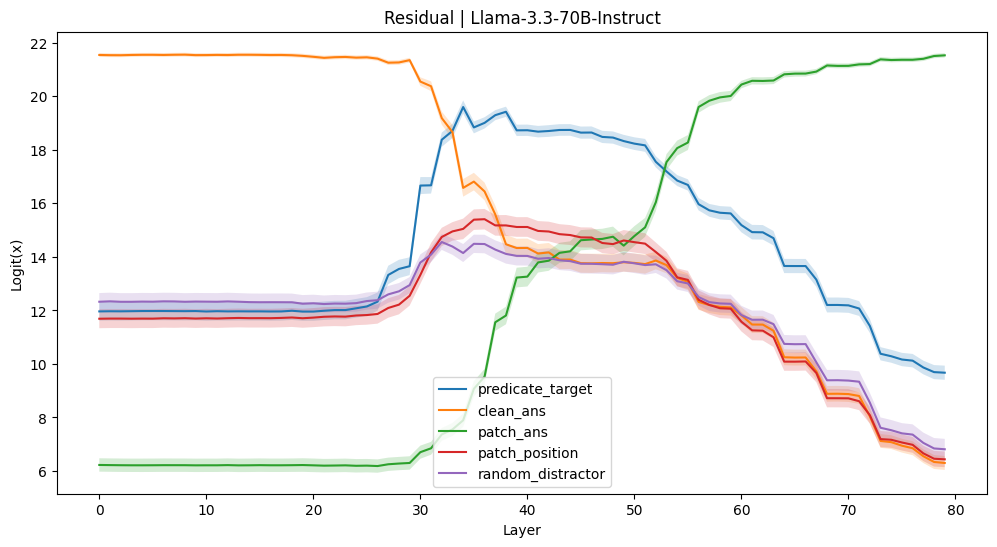

In [14]:
import numpy as np
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 6))
for token_type, layerwise_scores_list in scores.items():
    # Compute mean and std deviation across results for each layer
    mean_scores = np.mean(layerwise_scores_list, axis=0)
    sterr_scores = np.std(layerwise_scores_list, axis=0) / np.sqrt(len(layerwise_scores_list))

    plt.plot(mean_scores, label=f"{token_type}")
    plt.fill_between(range(len(mean_scores)), mean_scores - sterr_scores, mean_scores + sterr_scores, alpha=0.2)

plt.xlabel("Layer")
plt.ylabel("Logit(x)")
plt.title(f"Residual | {mt.name.split('/')[-1]}")
plt.legend()
plt.show()

## Loading and calculating the basis directions

In [11]:
import numpy as np

cached_states_dir = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/cached_states",
    mt.name.split("/")[-1],
    "last_token"
)
sample_file_name = "sample_00170.npz"

sample_states = np.load(
    os.path.join(cached_states_dir, sample_file_name),
    allow_pickle=True,
)
print(sample_states.files)
list(sample_states["states"].item().keys())

['sample', 'states']


['model.embed_tokens_<>_32',
 'model.layers.0.self_attn_<>_32',
 'model.layers.0.mlp_<>_32',
 'model.layers.0_<>_32',
 'model.layers.1.self_attn_<>_32',
 'model.layers.1.mlp_<>_32',
 'model.layers.1_<>_32',
 'model.layers.2.self_attn_<>_32',
 'model.layers.2.mlp_<>_32',
 'model.layers.2_<>_32',
 'model.layers.3.self_attn_<>_32',
 'model.layers.3.mlp_<>_32',
 'model.layers.3_<>_32',
 'model.layers.4.self_attn_<>_32',
 'model.layers.4.mlp_<>_32',
 'model.layers.4_<>_32',
 'model.layers.5.self_attn_<>_32',
 'model.layers.5.mlp_<>_32',
 'model.layers.5_<>_32',
 'model.layers.6.self_attn_<>_32',
 'model.layers.6.mlp_<>_32',
 'model.layers.6_<>_32',
 'model.layers.7.self_attn_<>_32',
 'model.layers.7.mlp_<>_32',
 'model.layers.7_<>_32',
 'model.layers.8.self_attn_<>_32',
 'model.layers.8.mlp_<>_32',
 'model.layers.8_<>_32',
 'model.layers.9.self_attn_<>_32',
 'model.layers.9.mlp_<>_32',
 'model.layers.9_<>_32',
 'model.layers.10.self_attn_<>_32',
 'model.layers.10.mlp_<>_32',
 'model.layers.

In [15]:
sample = SelectionSample.from_dict(sample_states["sample"].item())
tokenized = TokenizerOutput(data=sample.metadata["tokenized"])
print(torch.Tensor(tokenized.input_ids).shape)
print(mt.tokenizer.decode(tokenized.input_ids[0], skip_special_tokens=False))

torch.Size([1, 33])
# Options: Rice cooker, Spruce, Paper, Tractor, Bear, Kiwi, Monitor.
Which among these objects mentioned above is a electronics?
Answer:


In [17]:
import numpy as np

#######################################################
# LIMIT = 128
LIMIT = len(os.listdir(cached_states_dir))
#######################################################

cached_states = {}

for idx, file_name in enumerate(os.listdir(cached_states_dir)[:LIMIT]):
    sample_states = np.load(
        os.path.join(cached_states_dir, file_name), allow_pickle=True
    )
    states = {}
    for key, value in sample_states["states"].item().items():
        layer_idx, token_idx = key.split("_<>_")
        device = module_to_device(layer_idx)
        states[layer_idx] = torch.Tensor(value).to(mt.dtype).to(device)

    for layer_idx in states:
        if layer_idx not in cached_states:
            cached_states[layer_idx] = []
        cached_states[layer_idx].append(states[layer_idx])

    if (idx + 1) % 1000 == 0:
        logger.info(
            f"Processed {idx+1}/{LIMIT} files... ({(idx+1) / LIMIT * 100:.2f}%)"
        )

cached_states = {
    layer_name: torch.stack(cached_states[layer_name], dim=0)
    .to(mt.dtype)
    .to(module_to_device(layer_name))
    for layer_name in cached_states
}

free_gpu_cache()

for key in cached_states:
    print(f"{key}: {cached_states[key].device}, {cached_states[key].shape}")

2025-08-31 01:23:44 __main__ INFO     Processed 1000/12000 files... (8.33%)
2025-08-31 01:24:35 __main__ INFO     Processed 2000/12000 files... (16.67%)
2025-08-31 01:25:28 __main__ INFO     Processed 3000/12000 files... (25.00%)
2025-08-31 01:26:19 __main__ INFO     Processed 4000/12000 files... (33.33%)
2025-08-31 01:27:11 __main__ INFO     Processed 5000/12000 files... (41.67%)
2025-08-31 01:28:02 __main__ INFO     Processed 6000/12000 files... (50.00%)
2025-08-31 01:28:54 __main__ INFO     Processed 7000/12000 files... (58.33%)
2025-08-31 01:29:47 __main__ INFO     Processed 8000/12000 files... (66.67%)
2025-08-31 01:30:38 __main__ INFO     Processed 9000/12000 files... (75.00%)
2025-08-31 01:31:30 __main__ INFO     Processed 10000/12000 files... (83.33%)
2025-08-31 01:32:22 __main__ INFO     Processed 11000/12000 files... (91.67%)
2025-08-31 01:33:12 __main__ INFO     Processed 12000/12000 files... (100.00%)


NameError: name 'free_gpu_cache' is not defined

In [18]:
import os
from src.functional import free_gpu_cache
from src.utils.typing import SVD

basis_save_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "basis_directions",
    mt.name.split("/")[-1],
    "pca",
    "objects",
    "last_token",
)
os.makedirs(basis_save_path, exist_ok=True)

for layer_idx in cached_states:
    print(layer_idx)
    X = cached_states[layer_idx]
    X_centered = X - X.mean(dim=0, keepdim=True)
    svd = SVD.calculate(X_centered)
    basis_directions = svd.Vh.to(mt.dtype)
    with open(os.path.join(basis_save_path, f"{layer_idx}.pt"), "wb") as f:
        torch.save(basis_directions, f)

model.embed_tokens
model.layers.0.self_attn
model.layers.0.mlp
model.layers.0
model.layers.1.self_attn
model.layers.1.mlp
model.layers.1
model.layers.2.self_attn
model.layers.2.mlp
model.layers.2
model.layers.3.self_attn
model.layers.3.mlp
model.layers.3
model.layers.4.self_attn
model.layers.4.mlp
model.layers.4
model.layers.5.self_attn
model.layers.5.mlp
model.layers.5
model.layers.6.self_attn
model.layers.6.mlp
model.layers.6
model.layers.7.self_attn
model.layers.7.mlp
model.layers.7
model.layers.8.self_attn
model.layers.8.mlp
model.layers.8
model.layers.9.self_attn
model.layers.9.mlp
model.layers.9
model.layers.10.self_attn
model.layers.10.mlp
model.layers.10
model.layers.11.self_attn
model.layers.11.mlp
model.layers.11
model.layers.12.self_attn
model.layers.12.mlp
model.layers.12
model.layers.13.self_attn
model.layers.13.mlp
model.layers.13
model.layers.14.self_attn
model.layers.14.mlp
model.layers.14
model.layers.15.self_attn
model.layers.15.mlp
model.layers.15
model.layers.16.sel

In [19]:
from src.utils.typing import SVD

basis_save_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "basis_directions",
    mt.name.split("/")[-1],
    "svd",
    "objects",
    "last_token",
)
os.makedirs(basis_save_path, exist_ok=True)

for layer_idx in cached_states:
    print(layer_idx)
    svd = SVD.calculate(cached_states[layer_idx])
    basis_directions = svd.Vh.to(mt.dtype)
    with open(os.path.join(basis_save_path, f"{layer_idx}.pt"), "wb") as f:
        torch.save(basis_directions, f)

model.embed_tokens
model.layers.0.self_attn
model.layers.0.mlp
model.layers.0
model.layers.1.self_attn


model.layers.1.mlp
model.layers.1
model.layers.2.self_attn
model.layers.2.mlp
model.layers.2
model.layers.3.self_attn
model.layers.3.mlp
model.layers.3
model.layers.4.self_attn
model.layers.4.mlp
model.layers.4
model.layers.5.self_attn
model.layers.5.mlp
model.layers.5
model.layers.6.self_attn
model.layers.6.mlp
model.layers.6
model.layers.7.self_attn
model.layers.7.mlp
model.layers.7
model.layers.8.self_attn
model.layers.8.mlp
model.layers.8
model.layers.9.self_attn
model.layers.9.mlp
model.layers.9
model.layers.10.self_attn
model.layers.10.mlp
model.layers.10
model.layers.11.self_attn
model.layers.11.mlp
model.layers.11
model.layers.12.self_attn
model.layers.12.mlp
model.layers.12
model.layers.13.self_attn
model.layers.13.mlp
model.layers.13
model.layers.14.self_attn
model.layers.14.mlp
model.layers.14
model.layers.15.self_attn
model.layers.15.mlp
model.layers.15
model.layers.16.self_attn
model.layers.16.mlp
model.layers.16
model.layers.17.self_attn
model.layers.17.mlp
model.layers.1

## Loading the calculated basis directions

In [64]:
from src.functional import free_gpu_cache
basis_save_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "basis_directions",
    mt.name.split("/")[-1],
    "svd",
    "objects",
    "last_token",
)
basis_directions = {}
layer_names = [mt.layer_name_format.format(layer_idx) for layer_idx in range(28, 40)]

for layer_idx in layer_names:
    with open(os.path.join(basis_save_path, f"{layer_idx}.pt"), "rb") as f:
        basis_directions[layer_idx] = torch.load(f)# .to(f"cuda:{torch.cuda.device_count()-1}")
    print(
        layer_idx, basis_directions[layer_idx].shape, basis_directions[layer_idx].device
    )

free_gpu_cache()

model.layers.28 torch.Size([8192, 8192]) cuda:2
model.layers.29 torch.Size([8192, 8192]) cuda:2
model.layers.30 torch.Size([8192, 8192]) cuda:3
model.layers.31 torch.Size([8192, 8192]) cuda:3
model.layers.32 torch.Size([8192, 8192]) cuda:3
model.layers.33 torch.Size([8192, 8192]) cuda:3
model.layers.34 torch.Size([8192, 8192]) cuda:3
model.layers.35 torch.Size([8192, 8192]) cuda:3
model.layers.36 torch.Size([8192, 8192]) cuda:3
model.layers.37 torch.Size([8192, 8192]) cuda:3
model.layers.38 torch.Size([8192, 8192]) cuda:3
model.layers.39 torch.Size([8192, 8192]) cuda:3


## Train Subspace

In [65]:
from src.functional import get_module_nnsight

def apply_patch_with_projection(
    mt,
    clean_prompts,
    patch_prompts,
    projections,
    token_idx = -1,
):
    
    with mt.trace() as tracer:

        # cache states for patching
        patch_hs = {}
        with tracer.invoke(patch_prompts):
            for layer_name in projections:
                module = get_module_nnsight(mt, layer_name)
                current_states = (
                    module.output
                    if ("mlp" in layer_name or layer_name == mt.embedder_name)
                    else module.output[0]
                )
                if current_states.ndim == 2:
                    current_states = current_states.unsqueeze(0)
                patch_hs[layer_name] = current_states[:, token_idx, :].clone()
        
        # apply the patch
        with tracer.invoke(clean_prompts):
            for layer_name in projections:
                module = get_module_nnsight(mt, layer_name)
                current_states = (
                    module.output
                    if ("mlp" in layer_name or layer_name == mt.embedder_name)
                    else module.output[0]
                )
                if current_states.ndim == 2:
                    current_states = current_states.unsqueeze(0)
                clean_h = current_states[:, token_idx, :].clone()

                # apply the projection
                # print(f"{layer_name} | {patch_hs[layer_name].device=} | {projections[layer_name].device=}")
                device=clean_h.device
                patch_proj = torch.matmul(patch_hs[layer_name].to(device), projections[layer_name].to(device))
                clean_proj = torch.matmul(clean_h.to(device), projections[layer_name].to(device))
                current_states[:, token_idx, :] = clean_h - clean_proj + patch_proj
                # current_states[:, token_idx, :] = patch_hs[layer_name]
            
            # get the logits after the intervention
            logits = mt.lm_head.output[:, -1].save()

        # del patch_hs

    return logits

In [66]:
masks = {
    layer_name: torch.ones(
        mt.n_embd, 
        dtype=mt.dtype, 
        device=module_to_device(layer_name),
        # device=f"cuda:{torch.cuda.device_count()-1}",
        requires_grad=True
    )
    for layer_name in basis_directions.keys()
}

dummy_projections = {}
for layer_idx in basis_directions.keys():
    mask = masks[layer_idx]
    basis_direction = basis_directions[layer_idx]
    masked_directions = basis_direction * mask[:, None]
    dummy_projections[layer_idx] = masked_directions.t() @ masked_directions

In [25]:
from src.functional import free_gpu_cache
from src.selection.data import get_counterfactual_samples_within_task

free_gpu_cache()
train_set = []
train_limit = 512
# train_limit=64

while len(train_set) < train_limit:
    print(f"sample {len(train_set)+1} / {train_limit}")
    patch, clean = get_counterfactual_samples_within_task(
        mt=mt,
        task=select_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=prompt_template_idx,
        option_style=OPTION_STYLE,
        distinct_options=True,
        # n_distractors=N_DISTRACTORS,
        patch_n_distractors=N_DISTRACTORS,
        clean_n_distractors=N_DISTRACTORS
    )
    train_set.append((clean, patch))

len(train_set)

sample 1 / 512
2025-08-31 16:07:59 src.selection.data INFO     clean_obj_idx=5 | ['Cow', 'Phone', 'Ring', 'Coat', 'Bed', 'Bike']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-08-31 16:07:59 src.selection.data INFO     Options: Mango, Table, Jasmine, Dress, Towel, Boat.
Which among these objects mentioned above is a furniture?
Answer:
2025-08-31 16:07:59 src.selection.data INFO     Stool | furniture -> Table | pred=['" Table"[6771] (p=0.910, logit=22.375)', '" The"[578] (p=0.031, logit=19.000)', '" Among"[22395] (p=0.010, logit=17.875)', '" A"[362] (p=0.010, logit=17.875)', '" It"[1102] (p=0.005, logit=17.125)']
2025-08-31 16:07:59 src.selection.data INFO     Options: Cow, Phone, Ring, Coat, Bed, Bike.
Which among these objects mentioned above is a vehicle?
Answer:
2025-08-31 16:07:59 src.selection.data INFO     Van | vehicle -> Bike | pred=['" Bike"[38930] (p=0.793, logit=21.875)', '" The"[578] (p=0.065, logit=19.375)', '" Among"[22395] (p=0.051, logit=19.125)', '" A"[362]

512

In [67]:
from typing import Literal
from src.selection.utils import get_first_token_id

batch_size = 8

target_obj: Literal["predicate_target", "patch_position"] = "predicate_target"

targets = []
clean_samples = []
patch_samples = []

for clean_sample, patch_sample in train_set[: batch_size]:
    objs = {
        "predicate_target": clean_sample.metadata["track_type_obj_token_id"],
        "patch_position": get_first_token_id(
            clean_sample.options[patch_sample.obj_idx], mt.tokenizer, prefix=" "
        )
    }
    print(patch_sample.prompt())
    print(clean_sample.prompt())
    print(f"{objs[target_obj]}: {mt.tokenizer.decode(objs[target_obj])}")

    print("-" * 50)

    targets.append(objs[target_obj])
    patch_samples.append(patch_sample)
    clean_samples.append(clean_sample)

Options: Mango, Table, Jasmine, Dress, Towel, Boat.
Which among these objects mentioned above is a furniture?
Answer:
Options: Cow, Phone, Ring, Coat, Bed, Bike.
Which among these objects mentioned above is a vehicle?
Answer:
13394:  Bed
--------------------------------------------------
Options: Toilet paper, Ruler, Shirt, Accordion, Pendant, Bat.
Which among these objects mentioned above is a sport equipment?
Answer:
Options: Helmet, Pin, Mirror, Paper, Dishwasher, Ash.
Which among these objects mentioned above is a office supply?
Answer:
67629:  Helmet
--------------------------------------------------
Options: Daisy, Chain, Paper, Spruce, Trombone, Scooter.
Which among these objects mentioned above is a office supply?
Answer:
Options: Refrigerator, Cauliflower, Helmet, Sunflower, Pants, Highlighter.
Which among these objects mentioned above is a flower?
Answer:
57094:  Highlight
--------------------------------------------------
Options: Scooter, Charm, Coat, Eucalyptus, Apple, Hor

In [68]:
from src.tokens import prepare_input
from src.utils.typing import TokenizerOutput

prompts = []
prompts.extend([sample.prompt() for sample in clean_samples])
prompts.extend([sample.prompt() for sample in patch_samples])
tokenized = prepare_input(
    prompts=prompts, tokenizer=mt
)

clean_tokenized = TokenizerOutput(
    data={k: v[: len(clean_samples), :] for k, v in tokenized.items()}
)
patch_tokenized = TokenizerOutput(
    data={k: v[len(clean_samples) :, :] for k, v in tokenized.items()}
)

clean_tokenized.input_ids.shape, patch_tokenized.input_ids.shape

(torch.Size([8, 34]), torch.Size([8, 34]))

In [69]:
from src.functional import interpret_logits

logits = apply_patch_with_projection(
    mt=mt,
    clean_prompts=clean_tokenized,
    patch_prompts=patch_tokenized,
    projections=dummy_projections,
    token_idx=-1,
)   

mt._model.zero_grad()
free_gpu_cache()

print(f"{logits.shape=}")

for logit in logits:
    pred = interpret_logits(tokenizer=mt, logits = logit)
    print([f"{str(p)}" for p in pred])

target_logits = [logit[tok] for logit, tok in zip(logits, targets)]
print(target_logits)
torch.stack(target_logits).mean()

logits.shape=torch.Size([8, 128256])
['" Table"[6771] (p=0.707, logit=20.750)', '" The"[578] (p=0.084, logit=18.625)', '" A"[362] (p=0.066, logit=18.375)', '" Among"[22395] (p=0.024, logit=17.375)', '" Chair"[16478] (p=0.015, logit=16.875)']
['" Pin"[17929] (p=0.455, logit=19.500)', '" Paper"[18343] (p=0.312, logit=19.125)', '" The"[578] (p=0.062, logit=17.500)', '" A"[362] (p=0.026, logit=16.625)', '" Pen"[13597] (p=0.014, logit=16.000)']
['" Sun"[8219] (p=0.414, logit=20.500)', '" The"[578] (p=0.195, logit=19.750)', '" Caul"[90538] (p=0.134, logit=19.375)', '" Among"[22395] (p=0.082, logit=18.875)', '" A"[362] (p=0.063, logit=18.625)']
['" Jacket"[55870] (p=0.770, logit=21.875)', '" The"[578] (p=0.092, logit=19.750)', '" Among"[22395] (p=0.056, logit=19.250)', '" A"[362] (p=0.043, logit=19.000)', '" jacket"[27300] (p=0.007, logit=17.125)']
['" Sofa"[61948] (p=0.475, logit=19.875)', '" The"[578] (p=0.198, logit=19.000)', '" A"[362] (p=0.136, logit=18.625)', '" sofa"[32169] (p=0.039, l

tensor(14.3750, device='cuda:7', dtype=torch.bfloat16, grad_fn=<MeanBackward0>)

In [76]:
from torch.optim import Adam
from src.selection.data import SelectionSample


def get_optimal_projection(
    mt: ModelandTokenizer,
    train_set: list[tuple[SelectionSample, SelectionSample]],
    basis_directions: dict[str, torch.Tensor],
    target: Literal["predicate_target", "patch_position"] = "predicate_target",
    learning_rate: float = 1e-2,
    n_epochs: int = 5,
    lamb=1e-5,
    batch_size: int = 8,
):
    masks = {
        layer_name: torch.ones(
            mt.n_embd,
            dtype=mt.dtype,
            device=module_to_device(layer_name),
            # device=f"cuda:{torch.cuda.device_count()-1}",
            requires_grad=True,
        )
        for layer_name in basis_directions.keys()
    }
    optimizer = Adam(masks.values(), lr=learning_rate)

    batches = []
    for batch_start in range(0, len(train_set), batch_size):
        batches.append(train_set[batch_start : batch_start + batch_size])

    losses = []
    for epoch in range(n_epochs):
        epoch_loss = 0
        for batch_idx, batch in enumerate(batches):
            clean_samples, patch_samples = zip(*batch)

            prompts = []
            prompts.extend([sample.prompt() for sample in clean_samples])
            prompts.extend([sample.prompt() for sample in patch_samples])
            tokenized = prepare_input(prompts=prompts, tokenizer=mt)

            clean_tokenized = TokenizerOutput(
                data={k: v[: len(clean_samples), :] for k, v in tokenized.items()}
            )
            patch_tokenized = TokenizerOutput(
                data={k: v[len(clean_samples) :, :] for k, v in tokenized.items()}
            )
            batch_targets = []
            batch_distractors = []
            if target == "predicate_target":
                batch_targets = [
                    clean_sample.metadata["track_type_obj_token_id"]
                    for clean_sample in clean_samples
                ]
                batch_distractors = [
                    [
                        get_first_token_id(tokenizer=mt.tokenizer, name=opt, prefix=" ")
                        for idx, opt in enumerate(clean_sample.options)
                        if idx != clean_sample.metadata["track_type_obj_idx"]
                    ]
                ]
            elif target == "patch_position":
                batch_targets = [
                    get_first_token_id(clean_sample.options[patch_sample.obj_idx], tokenizer=mt.tokenizer, prefix=" ")
                    for clean_sample, patch_sample in zip(clean_samples, patch_samples)
                ]
                batch_distractors = [
                    [
                        get_first_token_id(tokenizer=mt.tokenizer, name=opt, prefix=" ")
                        for idx, opt in enumerate(clean_sample.options)
                        if idx != patch_sample.obj_idx
                    ]
                    for clean_sample, patch_sample in zip(clean_samples, patch_samples)
                ]
            # make sure that information about the patch options isn't being carried
            patch_options = [
                [
                    get_first_token_id(tokenizer=mt.tokenizer, name=opt, prefix=" ")
                    for opt in patch_sample.options
                ]
                for patch_sample in patch_samples
            ]

            projections = {}
            for layer_name in basis_directions.keys():
                mask = masks[layer_name]
                basis_direction = basis_directions[layer_name]
                # print(f"{layer_name} | {mask.device} | {basis_direction.device}")
                masked_directions = basis_direction * mask[:, None]
                # V directions are row-wise
                projections[layer_name] = masked_directions.t() @ masked_directions

            logits = apply_patch_with_projection(
                mt=mt,
                clean_prompts=clean_tokenized,
                patch_prompts=patch_tokenized,
                projections=projections,
                token_idx=-1,
            )

            # calculate target loss
            target_logits = [logit[tok] for logit, tok in zip(logits, batch_targets)]
            target_loss = -torch.stack(target_logits).mean()  # need this to go up

            # calculate distractor loss
            distractor_logits = [
                logit[distractor_tokens].mean()
                for logit, distractor_tokens in zip(logits, batch_distractors)
            ]
            distractor_loss = torch.stack(distractor_logits).mean()

            # patch option loss
            patch_option_logits = [
                logit[patch_option_tokens].mean()
                for logit, patch_option_tokens in zip(logits, patch_options)
            ]
            patch_option_loss = torch.stack(patch_option_logits).mean()

            # mask loss
            mask_l1_loss = None
            for mask in masks.values():
                if mask_l1_loss is None:
                    mask_l1_loss = lamb * mask.norm(p=1)
                else:
                    mask_l1_loss += lamb * mask.norm(p=1).to(mask_l1_loss.device)

            loss = target_loss + distractor_loss + patch_option_loss + mask_l1_loss.to(target_loss.device)
            logger.debug(
                f"Epoch={epoch+1} | {batch_idx=} |>> {target_loss.item():.4f} + {distractor_loss.item():.4f} + {patch_option_loss.item():.4f} + {mask_l1_loss.item():.4f} = {loss.item():.4f}"
            )

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # clamp the masks to [0, 1] after optimization step
            with torch.no_grad():
                for mask in masks.values():
                    mask.clamp_(0, 1)
                    mask += 1e-4 # to avoid zero gradients

            epoch_loss += loss.item()
            losses.append(loss.item())
            del (
                projections,
                logits,
            )
            free_gpu_cache()

        num_batches = (
            len(clean_samples) + batch_size - 1
        ) // batch_size  # ceiling division
        logger.debug(f"Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss / num_batches}")
        mt._model.zero_grad()
        free_gpu_cache()

    # build projections
    final_projections = {}
        
    for layer_name in basis_directions.keys():
        mask = masks[layer_name].clamp(0,1).round().detach()
        basis_direction = basis_directions[layer_name]
        masked_directions = basis_direction * mask[:, None]
        # V directions are row-wise
        final_projections[layer_name] = masked_directions.t() @ masked_directions
        masks[layer_name] = mask.cpu()

    metadata = {
        "losses": losses,
        "masks": masks,
    }

    return final_projections, metadata

In [79]:
mt._model.zero_grad()
free_gpu_cache()

In [ ]:
projections, metadata = get_optimal_projection(
    mt=mt,
    train_set=train_set,
    basis_directions=basis_directions,
    lamb=1e-3,
    learning_rate=1e-2,
    batch_size=8,
    n_epochs=5,
)

2025-08-31 19:54:37 __main__ DEBUG    Epoch=1 | batch_idx=0 |>> -14.3750 + 5.5000 + 7.5000 + 97.5000 = 96.0000
2025-08-31 19:54:41 __main__ DEBUG    Epoch=1 | batch_idx=1 |>> -10.8125 + 6.5938 + 7.0938 + 96.5000 = 99.5000
2025-08-31 19:54:45 __main__ DEBUG    Epoch=1 | batch_idx=2 |>> -13.0625 + 6.8438 + 6.5625 + 96.0000 = 96.5000
2025-08-31 19:54:50 __main__ DEBUG    Epoch=1 | batch_idx=3 |>> -13.6250 + 5.2812 + 7.6875 + 95.5000 = 95.0000
2025-08-31 19:54:53 __main__ DEBUG    Epoch 1/1, Loss: 387.0


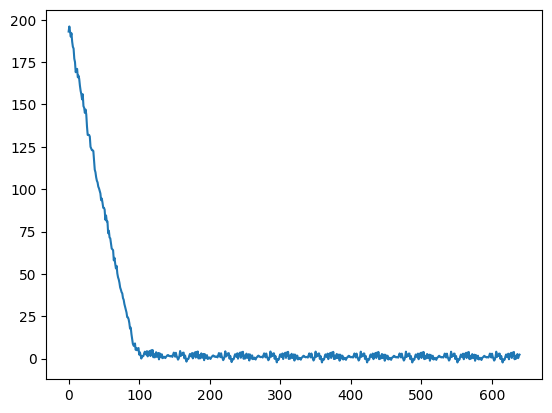

In [41]:
from matplotlib import pyplot as plt 
plt.plot(metadata["losses"])
plt.show()

In [42]:
import numpy as np
npz_file = "save_test_subspace.npz"

with open(npz_file, "wb") as f:
    np.savez_compressed(
        f,
        losses=metadata["losses"],
        masks={
            layer_name: mask.cpu().to(torch.float32).detach().numpy()
            for layer_name, mask in metadata["masks"].items()
        },
        allow_pickle=True,
    )

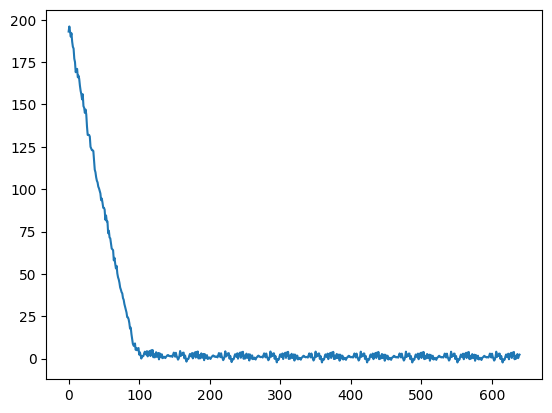

In [43]:
subspace_optimization_results = np.load(npz_file, allow_pickle=True)
plt.plot(subspace_optimization_results["losses"])
plt.show()

In [44]:
from src.functional import free_gpu_cache
from src.selection.data import get_counterfactual_samples_within_task

free_gpu_cache()
validation_set = []
validation_limit = 256
# validation_limit=64

while len(validation_set) < validation_limit:
    print(f"sample {len(validation_set)+1} / {validation_limit}")
    patch, clean = get_counterfactual_samples_within_task(
        mt=mt,
        task=select_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=prompt_template_idx,
        option_style=OPTION_STYLE,
        distinct_options=True,
        # n_distractors=N_DISTRACTORS,
        patch_n_distractors=N_DISTRACTORS,
        clean_n_distractors=N_DISTRACTORS
    )
    validation_set.append((clean, patch))
len(validation_set)

sample 1 / 256
2025-08-31 17:58:57 src.selection.data INFO     clean_obj_idx=2 | ['Sweater', 'Car', 'Marker', 'Cauliflower', 'Raspberry', 'Chair']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-08-31 17:58:57 src.selection.data INFO     Options: Nightstand, Eraser, Banana, Baseball, Gloves, Zucchini.
Which among these objects mentioned above is a vegetable?
Answer:
2025-08-31 17:58:57 src.selection.data INFO     Carrot | vegetable -> Zucchini | pred=['" Z"[1901] (p=0.836, logit=22.125)', '" Among"[22395] (p=0.061, logit=19.500)', '" The"[578] (p=0.061, logit=19.500)', '" A"[362] (p=0.007, logit=17.375)', '" There"[2684] (p=0.003, logit=16.625)']
2025-08-31 17:58:57 src.selection.data INFO     Options: Sweater, Car, Marker, Cauliflower, Raspberry, Chair.
Which among these objects mentioned above is a office supply?
Answer:
2025-08-31 17:58:57 src.selection.data INFO     Stapler | office supply -> Marker | pred=['" Marker"[40975] (p=0.840, logit=22.125)', '" The"[578] (p=0.05

256

In [62]:
from src.functional import predict_next_token

clean_sample, patch_sample = validation_set[40]

print(patch_sample.prompt(), ">>", patch_sample.obj)
print(clean_sample.prompt(), ">>", clean_sample.obj)

clean_tokenized = prepare_input(prompts=[clean_sample.prompt()], tokenizer=mt)
patch_tokenized = prepare_input(prompts=[patch_sample.prompt()], tokenizer=mt)

track_tokens = {
    "clean_obj": get_first_token_id(
        clean_sample.obj, tokenizer=mt.tokenizer, prefix=" "
    ),
    "patch_obj": get_first_token_id(
        patch_sample.obj, tokenizer=mt.tokenizer, prefix=" "
    ),
    "predicate_target": clean_sample.metadata["track_type_obj_token_id"],
    "patch_position": get_first_token_id(
        clean_sample.options[patch_sample.obj_idx], tokenizer=mt.tokenizer, prefix=" "
    ),
}

interested_tokens = list(
    set(
        list(track_tokens.values())
        + [
            get_first_token_id(opt, tokenizer=mt.tokenizer, prefix=" ")
            for opt in clean_sample.options
        ]
    )
)
clean_pred, clean_track = predict_next_token(
    mt=mt, inputs=clean_tokenized, token_of_interest=interested_tokens
)
logger.info(f"clean_pred={[str(pred) for pred in clean_pred]}")
logger.info(f"{clean_track=}")

Options: Bookshelf, Mirror, Celery, Ring, Boat, Willow.
Which among these objects mentioned above is a furniture?
Answer: >> Bookshelf
Options: Notebook, Table, Hairdryer, Mixer, Magnolia, Cherry.
Which among these objects mentioned above is a bathroom item?
Answer: >> Hairdryer
2025-08-31 18:18:49 __main__ INFO     clean_pred=["[PredictedToken(token=' Hair', prob=0.8828125, logit=21.625, token_id=26781, metadata=None), PredictedToken(token=' The', prob=0.038818359375, logit=18.5, token_id=578, metadata=None), PredictedToken(token=' A', prob=0.0234375, logit=18.0, token_id=362, metadata=None), PredictedToken(token=' Among', prob=0.020751953125, logit=17.875, token_id=22395, metadata=None), PredictedToken(token=' hair', prob=0.004638671875, logit=16.375, token_id=7013, metadata=None)]"]
2025-08-31 18:18:49 __main__ INFO     clean_track=[OrderedDict([(26781, (1, PredictedToken(token=' Hair', prob=0.8828125, logit=21.625, token_id=26781, metadata=None))), (6771, (6, PredictedToken(token='

In [63]:
proj_logits = apply_patch_with_projection(
    mt=mt,
    clean_prompts=clean_tokenized,
    patch_prompts=patch_tokenized,
    projections=projections,
    token_idx=-1
)

proj_pred, proj_track = interpret_logits(
    tokenizer=mt.tokenizer,
    logits=proj_logits,
    interested_tokens=interested_tokens
)
logger.info(f"proj_pred={[str(pred) for pred in proj_pred]}")
logger.info(f"{proj_track=}")

2025-08-31 18:18:53 __main__ INFO     proj_pred=['" Hair"[26781] (p=0.875, logit=21.625)', '" The"[578] (p=0.043, logit=18.625)', '" A"[362] (p=0.026, logit=18.125)', '" Among"[22395] (p=0.021, logit=17.875)', '" hair"[7013] (p=0.005, logit=16.375)']
2025-08-31 18:18:53 __main__ INFO     proj_track=OrderedDict([(26781, (1, PredictedToken(token=' Hair', prob=0.875, logit=21.625, token_id=26781, metadata=None))), (6771, (6, PredictedToken(token=' Table', prob=0.003143310546875, logit=16.0, token_id=6771, metadata=None))), (72392, (33, PredictedToken(token=' Mixer', prob=0.000274658203125, logit=13.5625, token_id=72392, metadata=None))), (69755, (65, PredictedToken(token=' Notebook', prob=8.392333984375e-05, logit=12.375, token_id=69755, metadata=None))), (20918, (72, PredictedToken(token=' Magn', prob=6.151199340820312e-05, logit=12.0625, token_id=20918, metadata=None))), (45805, (301, PredictedToken(token=' Cherry', prob=3.248453140258789e-06, logit=9.125, token_id=45805, metadata=None)

In [58]:
mt.tokenizer.decode(track_tokens["predicate_target"])

' Drum'